In [1]:
import os
import pathlib
from typing import List
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

d:\0_amri_local\11_aqi_forecast\conda_aqi_forecast\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
%load_ext autoreload
%autoreload 2

from helper_functions import epa_taiwan_data_pipeline
from models import lstnet_gokul

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Set the random seed to 420
pl.seed_everything(420)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Global seed set to 420


In [5]:
year = 2018
site_name = "Banqiao"
columns = ["SiteEngName","PM2.5","AMB_TEMP","CH4",'CO',"NMHC","read_time"]

# import data
pm25_df = epa_taiwan_data_pipeline.import_epa_data(site_name=site_name, year=year)[columns]

# basic preprocessing
pm25_df = epa_taiwan_data_pipeline.standardize_df(pm25_df)

In [6]:
train_split = 0.6

train_data = pm25_df.iloc[:int(len(pm25_df)*train_split),:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(train_data)}")
train_data.tail(2)

All data length:8760 
Train data length:5256


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399305,Banqiao,8.0,30.2,1.8,0.30,0.08,2018-08-07 22:00:00
399381,Banqiao,9.0,29.9,1.8,0.23,0.06,2018-08-07 23:00:00


In [7]:
normalized_columns = ['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc']
normalized_column_names = []
for column in normalized_columns:
    normalized_column_name = column + '_normalized'
    normalized_column_names.append(normalized_column_name)
    train_data[normalized_column_name] = (train_data[column] - train_data[column].min()) / (train_data[column].max() - train_data[column].min())

In [8]:
# verify dataset instances
temp_train_dataset = epa_taiwan_data_pipeline.AqiDataset(train_data, history_len=48, col_names=[normalized_column_names[0]], device=device)
print(len(temp_train_dataset))
x, y = temp_train_dataset[0]
print(x.shape, y.shape)

5208
torch.Size([48, 1]) torch.Size([1])


In [9]:
# train data_loader
temp_train_data_loader = DataLoader(temp_train_dataset, batch_size=4)
X, Y = next(iter(temp_train_data_loader))
print(X.shape, Y.shape)

torch.Size([4, 48, 1]) torch.Size([4, 1])


In [11]:
# test the model
temp_model = lstnet_gokul.LSTNet_lightning(ar_window_size=7, num_features=1, recc1_out_channels=64, conv1_out_channels=32)#.to(device)

trainer = pl.Trainer(max_epochs=2, accelerator='gpu')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(temp_model, temp_train_data_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 256   
1 | recc1      | GRU        | 18.8 K
2 | dropout    | Dropout    | 0     
3 | skip_reccs | ModuleList | 912   
4 | output     | Linear     | 177   
5 | ar         | Linear     | 8     
------------------------------------------
20.2 K    Trainable params
0         Non-trainable params
20.2 K    Total params
0.081     Total estimated model params size (MB)
d:\0_amri_local\11_aqi_forecast\conda_aqi_forecast\Lib\site-packages\lightning\pytorch\trainer\connectors\d

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [13]:
metrics = pd.read_csv(r"D:\0_amri_local\11_aqi_forecast\notebooks\lightning_logs\version_0\metrics.csv")

<Axes: xlabel='step'>

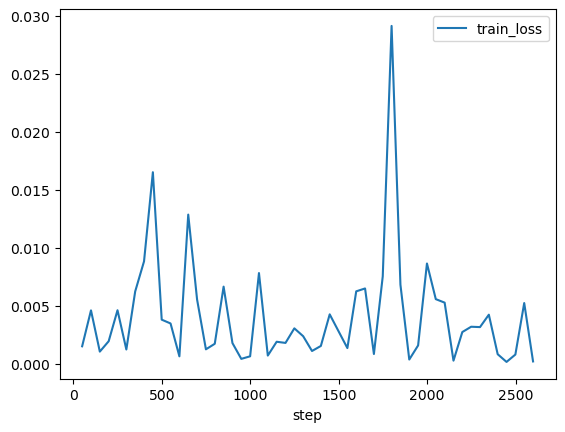

In [14]:
metrics.plot(
    x='step',
    y='train_loss'
)